In [ ]:
# Load Libraries

import os
from torchvision.datasets.folder import default_loader
from torchvision.transforms import ToTensor, Compose
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


: 

In [ ]:
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
from PIL import Image

def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the lstm sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
    return clips

root_direct = os.path.dirname('./UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/')

def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(root_direct)):
        directory_path = join(root_direct, f)
        if isdir(directory_path):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "tif":
                    img = Image.open(img_path).resize((256, 256))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return np.array(clips)

# Convert the numpy array to a tensor
clips_tensor = torch.tensor(get_training_set(), dtype=torch.float32)

# Create the dataset from the tensor
dataset = TensorDataset(clips_tensor)

# ... [rest of your code] ...

# Now you can split your dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
print(len(dataset))

In [ ]:
 # Helping functions

def plot_image_tensor(tensor_image):
    # CxHxW to HxWxC or getting invalid dimensions
    tensor_image = tensor_image.permute(1, 2, 0)  
    plt.imshow(tensor_image.numpy())
    plt.title('Single Image')
    plt.axis('off') 
    plt.show()

    


In [ ]:
augment_transforms = [
    transforms.Compose([ 
        transforms.ToTensor()
    ]),
    
]

root_direct = os.path.dirname('./UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/')
images = []

for subfolder in os.listdir(root_direct):
    for img_file in os.listdir(os.path.join(root_direct, subfolder)):
        img_path = os.path.join(root_direct, subfolder, img_file)
        original_img = default_loader(img_path)
        original_img = original_img.resize((238, 158))  # Resize if necessary

        # Apply each augmentation
        for transform in augment_transforms:
            augmented_img = transform(original_img)
            images.append(augmented_img)

# Convert images to tensors
images_tensor = torch.stack(images, dim=0)
print(images_tensor.shape)

dataset = TensorDataset(images_tensor)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size , val_size])



In [2]:
import os
import torch
from torchvision import transforms
from torchvision.datasets.folder import default_loader
from torch.utils.data import TensorDataset, random_split

# Define your transformations
augment_transforms = [
    transforms.Compose([
        transforms.Resize((238, 158)),  # Resize if necessary
        transforms.ToTensor()           # Convert to tensor
    ]),
]

root_direct = os.path.dirname('./UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/')
sequences = []  # This will hold the training sequences

# Define the sequence function
def get_sequences_from_folder(folder_path, stride, sequence_length=10):
    image_files = sorted([file for file in os.listdir(folder_path) if file.endswith('.tif')])
    sequences = []
    for start_idx in range(0, len(image_files), stride * sequence_length):
        sequence_files = image_files[start_idx:start_idx + stride * sequence_length:stride]
        if len(sequence_files) == sequence_length:
            sequence = [default_loader(os.path.join(folder_path, f)) for f in sequence_files]
            transformed_sequence = [augment_transforms[0](img) for img in sequence]
            sequence_tensor = torch.stack(transformed_sequence, dim=0)
            sequences.append(sequence_tensor)
    return sequences

# Generate sequences with different strides
for subfolder in os.listdir(root_direct):
    subfolder_path = os.path.join(root_direct, subfolder)
    if os.path.isdir(subfolder_path):
        for stride in range(1, 3):  # Here, we use stride values of 1 and 2
            sequences.extend(get_sequences_from_folder(subfolder_path, stride))

# Stack all the sequences together to create the final dataset tensor
sequences_tensor = torch.stack(sequences, dim=0)
print(sequences_tensor.shape)

# Create the dataset from the tensor
dataset = TensorDataset(sequences_tensor)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


torch.Size([1020, 10, 3, 238, 158])


In [ ]:
# Testing the dataset

# Create an iterator from the DataLoader
train_loader_iter = iter(train_loader)

# Fetch the next batch
batch = next(train_loader_iter)

# Process and display the batch
print(batch[0].shape)  # Assuming batch[0] contains your images
plot_image_tensor(batch[0][0])  # Plot the first image from the batch

In [3]:
# Define the model
import torch
import torch.nn as nn
from torchvision import models

class VGGConvLSTMAutoencoder(nn.Module):
    def __init__(self, hidden_dim, kernel_size):
        super(VGGConvLSTMAutoencoder, self).__init__()

        # Load VGG19 with pre-trained weights, remove its classifier
        vgg19 = models.vgg19(pretrained=True)
        self.encoder = nn.Sequential(*list(vgg19.features.children()))
       
        for param in list(self.encoder.parameters())[-15:]:
            param.requires_grad = False 
            
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Batch Normalization layer
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Batch Normalization layer
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(128, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),  # Batch Normalization layer
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(256, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),  # Batch Normalization layer
            nn.LeakyReLU(0.1)
        )


        # ConvLSTM as decoder
        self.decoder = ConvLSTM(
            input_channels=512,  # VGG19's last feature map has 512 channels
            hidden_dim=hidden_dim,
            kernel_size=kernel_size
        )
        
        self.dropout = nn.Dropout(p=0.8)  # 80% dropout
        
    def forward(self, x): 
        # Assuming input_tensor is your input with shape [50, 10, 3, 238, 158]
        batch_size, sequence_length, channels, height, width = x.shape
        # Reshape input to process each frame individually
        x = x.view(batch_size * sequence_length, channels, height, width)

        # Encode
        x = self.encoder(x) 
        x = self.dropout(x)
       
        # Apply Batch Normalization after the first convolutional layer in the bottleneck
        x = self.bottleneck(x)
        x = self.dropout(x)
        x = self.decoder(x) 
        
        

        return x


class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_dim, kernel_size=3, bias=True):
        super(ConvLSTMCell, self).__init__()
        self.input_channels = input_channels
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.bias = bias
        '''
        print( "input_channels ", input_channels)
        print( "hidden_dim ", hidden_dim )
        print( "kernel_size  ", kernel_size)
        print( "padding ", self.padding)
        print("self.input_channels + self.hidden_dim", self.input_channels + self.hidden_dim)
        '''
        # Adjusted in_channels to be input_channels + hidden_dim
        self.conv = nn.Conv2d(in_channels=self.input_channels + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding, bias=self.bias)


    def forward(self, x, state):
        # print(self.conv)
        h_cur, c_cur = state
        # concatenate along channel axis
        combined = torch.cat([x, h_cur], dim=1)
        conv_out = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_out, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        # print('h_h: ', (batch_size, self.hidden_dim, height, width))
        return (torch.zeros(batch_size, self.hidden_dim, height, width).to(device),
                torch.zeros(batch_size, self.hidden_dim, height, width).to(device))


class ConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_dim, kernel_size, output_channels=3):
        super(ConvLSTM, self).__init__()

        self.hidden_dim = hidden_dim

        # Creating a single ConvLSTM layer
        self.layer = ConvLSTMCell(
            input_channels=input_channels, hidden_dim=hidden_dim, kernel_size=kernel_size)

        
        self.upconv1 = nn.ConvTranspose2d(hidden_dim, hidden_dim // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_dim // 2)  # Batch Normalization layer
        self.relu1 = nn.LeakyReLU(0.1)
        self.upconv2 = nn.ConvTranspose2d(hidden_dim // 2, hidden_dim // 4, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_dim // 4)  # Batch Normalization layer
        self.relu2 = nn.LeakyReLU(0.1)
        self.final_conv = nn.Conv2d(hidden_dim // 4, 3, kernel_size=3, padding=1)
                # Adaptive pooling layer to resize to 158x238
        self.adaptive_pool = nn.AdaptiveAvgPool2d((158, 238))


    def forward(self, x):
        b, _, h, w = x.size()
        hidden_state = self.layer.init_hidden(b, (h, w))
        h_t, c_t = self.layer(x, hidden_state)

        x = self.upconv1(h_t)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.upconv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.final_conv(x)
# Resizing to the desired output dimensions
        x_reconstructed = self.adaptive_pool(x)

        return x_reconstructed

In [4]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Epoch [1/10] Average Training Loss: 0.0091
Validation Loss after Epoch 1: 0.0049
Epoch: 0 LR: 0.0001
Epoch [2/10] Average Training Loss: 0.0048
Validation Loss after Epoch 2: 0.0048
Epoch: 1 LR: 0.0001
Epoch [3/10] Average Training Loss: 0.0047
Validation Loss after Epoch 3: 0.0047
Epoch: 2 LR: 0.0001
Epoch [4/10] Average Training Loss: 0.0047
Validation Loss after Epoch 4: 0.0048
Epoch: 3 LR: 0.0001
Epoch [5/10] Average Training Loss: 0.0047
Validation Loss after Epoch 5: 0.0048
Epoch: 4 LR: 0.0001
Epoch [6/10] Average Training Loss: 0.0046
Validation Loss after Epoch 6: 0.0046
Epoch: 5 LR: 0.0001
Epoch [7/10] Average Training Loss: 0.0046
Validation Loss after Epoch 7: 0.0047
Epoch: 6 LR: 0.0001
Epoch [8/10] Average Training Loss: 0.0046
Validation Loss after Epoch 8: 0.0051
Epoch: 7 LR: 0.0001
Epoch [9/10] Average Training Loss: 0.0046
Validation Loss after Epoch 9: 0.0047
Epoch: 8 LR: 0.0001
Epoch [10/10] Average Training Loss: 0.0046
Validation Loss after Epoch 10: 0.0048
Epoch: 9

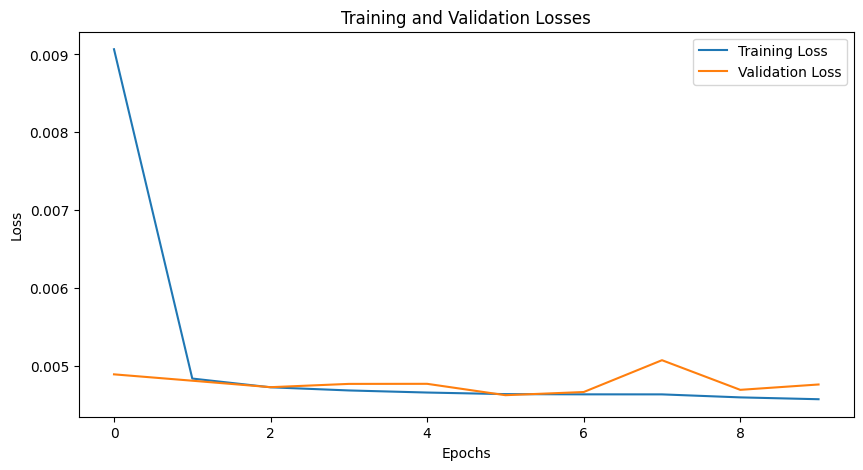

In [9]:
#Train the model

torch.cuda.empty_cache()

batch_size = 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

hidden_dim = 200
kernel_size = 3
num_layers = 1

model = VGGConvLSTMAutoencoder(hidden_dim=hidden_dim, kernel_size=kernel_size)
model = nn.DataParallel(model)
model.to(device)

criterion = nn.MSELoss()


# Assuming `model` is your PyTorch model
l2_lambda = 0.001  # This is your weight decay coefficient

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=l2_lambda, eps=1e-6)


# Define scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Early Stopping Parameters
early_stopping_patience = 5
epochs_no_improve = 0
min_val_loss = float('inf')

train_losses = []
val_losses = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    num_batches = 0
    for i, (images,) in enumerate(train_loader):
        images = images.to(device)
        outputs = model(images)
        
        #print("Output shape:", outputs.shape)
        #print("Image shape:", images.shape)

 
        outputs_reshaped = outputs.unsqueeze(0)  # This will change shape from [10, 3, 158, 238] to [1, 10, 3, 158, 238]    
        # Assuming output_reshaped is your tensor with shape [1, 10, 3, 158, 238]
        output_reshaped_permuted = outputs_reshaped.permute(0, 1, 2, 4, 3)  # This will change shape to [1, 10, 3, 238, 158]

        #print("Output Reshape:", outputs_reshaped.shape)
        loss = criterion(output_reshaped_permuted, images)

        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f'Epoch [{epoch + 1}/{num_epochs}] Average Training Loss: {average_loss:.4f}')
    
    

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for (images, ) in val_loader:
            images = images.to(device)
            outputs = model(images)
            outputs_reshaped = outputs.unsqueeze(0)  # This will change shape from [10, 3, 158, 238] to [1, 10, 3, 158, 238]    
        # Assuming output_reshaped is your tensor with shape [1, 10, 3, 158, 238]
            output_reshaped_permuted = outputs_reshaped.permute(0, 1, 2, 4, 3)  # This will change shape to [1, 10, 3, 238, 158]
        
            val_loss += criterion(output_reshaped_permuted, images).item()
        val_loss /= len(val_loader)
        print(f'Validation Loss after Epoch {epoch+1}: {val_loss:.4f}')

    # Step the scheduler (only once per epoch)
    scheduler.step(val_loss)
    for param_group in optimizer.param_groups:
        print("Epoch:", epoch, "LR:", param_group['lr'])
    
    # Log the average losses
    train_losses.append(average_loss)
    val_losses.append(val_loss)

    # Early stopping check
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print('Early stopping triggered!')
            break

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Save the entire model
torch.save(model, 'model.pth')

In [ ]:
from PIL import Image

# Load the model
model = torch.load('model.pth')


# load one image for testing 
image_path = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001/112.tif'
# from training set 
#image_path = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train001/120.tif'
image = Image.open(image_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([ 
     transforms.Grayscale(num_output_channels=3),
     transforms.Resize((158, 238)),
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

image = transform(image).to(device)
image = image.unsqueeze(1).unsqueeze(1)  # Add a batch dimension at the front 
image = image.permute(1,2, 0, 3, 4)  # Rearranges to [1, 3, 158, 238, 1]

print(image.shape)

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(image).to(device)
    print("Output shape:", output.shape)

# Convert to NumPy arrays for visualization
np_image = image.squeeze().cpu().numpy()
np_output = output.squeeze().cpu().numpy()

# If the images have channels as the first dimension, transpose them to (H, W, C)
if np_image.shape[0] in (1, 3):
    np_image = np_image.transpose(1, 2, 0)
if np_output.shape[0] in (1, 3):
    np_output = np_output.transpose(1, 2, 0)




# Calculate the absolute difference
difference = np.abs(np_image - np_output) 

# Calculate the MSE
mse = np.mean((np_image - np_output) ** 2)

print("Mean Squared Error:", mse)

# Create a heatmap to visualize the differences
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(np_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np_output, cmap='gray')
plt.title('Output Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(difference, cmap='hot')
plt.title('Difference Heatmap')
plt.axis('off')

plt.show()



: 